# MEDICAL IMAGE RETRIEVAL SYSTEM FOR ISIC 2017

In [7]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset 
from timm import create_model
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import cosine_similarity 
from tqdm import tqdm
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 80
NUM_CLASSES = 3  
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 5e-4  
NUM_EPOCHS = 3
LAMBDA_KOLEO = 0.3  
BETA = 0.5
# Directories
train_dir = '/kaggle/input/isic-2017-original-dataset/isic 2017/ISIC-2017_Training_Data'
val_dir = '/kaggle/input/isic-2017-original-dataset/isic 2017/ISIC-2017_Validation_Data'
test_dir = '/kaggle/input/isic-2017-original-dataset/isic 2017/ISIC-2017_Test_v2_Data'

train_csv = '/kaggle/input/csv-files/training.csv'
val_csv = '/kaggle/input/csv-files/validation.csv'
test_csv = '/kaggle/input/csv-files/testing.csv'

In [9]:
train_df = pd.read_csv(train_csv)
train_df.head()

,image_id,label
0,ISIC_0000000.jpg,0
1,ISIC_0000001.jpg,0
2,ISIC_0000002.jpg,1
3,ISIC_0000003.jpg,0
4,ISIC_0000004.jpg,1


In [10]:
train_df['label'].value_counts()

label
0    1372
1     374
2     254
Name: count, dtype: int64

In [11]:
# label 0 ==> Nevus
# label 1 ==> Melanoma
# label 2 ==> Seborrheic keratosis

# Custom Dataset

In [12]:
class MedicalImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.data_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Load Data

In [14]:
train_dataset = MedicalImageDataset(train_csv, train_dir, transform=transform)
val_dataset = MedicalImageDataset(val_csv, val_dir, transform=transform)
test_dataset = MedicalImageDataset(test_csv, test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
from torch.utils.data import ConcatDataset

# Combine the train and validation datasets for training
combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

# Create DataLoader with the combined dataset
train_loader_combined = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [10]:
class MIRViT(nn.Module):
    def __init__(self):
        super(MIRViT, self).__init__()
        self.vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)
        self.classifier = nn.Linear(384, NUM_CLASSES)

    def forward(self, x):
        features = self.vit(x)
        return features

    def get_embedding(self, x):
        with torch.no_grad():
            features = self.vit(x)
        return features

# Contrastive Learning

In [11]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def contrastive_loss(embeddings, labels):
    N = embeddings.size(0)
    loss = 0.0
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)  #noralize embeddings
    for i in range(N):
        z_i = embeddings[i]
        y_i = labels[i]
        
        positive_sum = 0.0
        negative_sum = 0.0
        positive_count = 0
        negative_count = 0
        
        for j in range(N):
            if i != j:
                z_j = embeddings[j]
                y_j = labels[j]
                sim = torch.clamp(torch.dot(z_i, z_j), min=-1.0, max=1.0)

                if y_i == y_j:
                    positive_sum += (1 - sim)
                    positive_count += 1
                else:
                    negative_sum += max(0, sim - BETA)
                    negative_count += 1
        
        positive_term = positive_sum / (positive_count + 1e-8)
        negative_term = negative_sum / (negative_count + 1e-8)
        loss += positive_term + negative_term
    
    return loss / N

def koleo_loss(embeddings):
    similarity_matrix = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    mask = torch.eye(similarity_matrix.size(0), device=embeddings.device).bool()
    similarity_matrix[mask] = -1e6  # Replace diagonal with large negative value

    min_similarity, _ = torch.min(similarity_matrix, dim=1)
    rho_i = torch.clamp(min_similarity + 1e-8, min=1e-8)  # Ensure positivity
    return -torch.mean(torch.log(rho_i))

In [12]:
def train_model(model, train_loader, optimizer, lambda_koleo=0.3):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        embeddings = model(images)
        contrastive_loss_value = contrastive_loss(embeddings, labels)
        # print("contrastive_loss_value = ", contrastive_loss_value)
        
        koleo_loss_value = koleo_loss(embeddings)
        # print("koleo_loss_value = ", koleo_loss_value)
        
        total_loss_value = contrastive_loss_value + lambda_koleo * koleo_loss_value
        if torch.isnan(total_loss_value):
            # print("NaN detected, skipping this batch!")
            continue
        
        total_loss_value.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += total_loss_value.item()
        # print("total_loss = ", total_loss)
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch Loss: {avg_loss:.4f}")

In [13]:
def evaluate_model(model, test_loader, normalize_embeddings=True):
    model.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)  # Move images to the same device as the model
            labels = labels.to(device)  # Move labels if needed
            embeddings = model.get_embedding(images)
            
            if normalize_embeddings:
                embeddings = F.normalize(embeddings, p=2, dim=1)
            
            all_embeddings.append(embeddings)
            all_labels.append(labels)
    
    # Concatenate all embeddings and labels
    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    
    return all_embeddings, all_labels 

In [14]:
# Initialize Model and Optimizer
model = MIRViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Train the Model 

In [15]:
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}') 
    train_model(model, train_loader_combined, optimizer) 

Epoch 1/3


100%|██████████| 27/27 [08:11<00:00, 18.22s/it]


Epoch Loss: 5.9922
Epoch 2/3


100%|██████████| 27/27 [06:57<00:00, 15.46s/it]


Epoch Loss: 5.9107
Epoch 3/3


100%|██████████| 27/27 [06:56<00:00, 15.41s/it]

Epoch Loss: 5.8571


In [38]:
# Evaluate the Model
train_embeddings, train_labels = evaluate_model(model, train_loader) 
test_embeddings, test_labels = evaluate_model(model, test_loader) 

In [17]:
# Move the tensors to CPU and then convert to NumPy arrays
np.savez("/kaggle/input/embeddings/embeddings_and_labels_(mAP_ 0.7457).npz",
         train_embeddings=train_embeddings.cpu().numpy(),
         train_labels=train_labels.cpu().numpy(),
         test_embeddings=test_embeddings.cpu().numpy(),
         test_labels=test_labels.cpu().numpy())
print("Embeddings and labels saved to embeddings_and_labels.npz") 

Embeddings and labels saved to embeddings_and_labels.npz


In [33]:
# Cosine Similarity for Retrieval 
def retrieve_images(query_embedding, database_embeddings, top_k=10):
    """Retrieve top K images based on cosine similarity."""
    similarities = cosine_similarity(query_embedding.cpu().numpy(), database_embeddings.cpu().numpy())
    indices = np.argsort(-similarities, axis=1)[:, :top_k]
    return indices

def calculate_average_precision(true_labels, retrieved_labels):
    """Calculates Average Precision (AP) for a single query."""
    hits, score_sum, relevant_count = 0, 0.0, 0
    for idx, label in enumerate(retrieved_labels):
        if label == true_labels:
            hits += 1
            relevant_count += 1
            score_sum += hits / (idx + 1)  # Precision at this rank

    if relevant_count == 0:
        return 0.0
    return score_sum / relevant_count

def calculate_map(query_labels, retrieved_labels):
    """Calculates Mean Average Precision (mAP) for all queries."""
    ap_scores = []
    for true_label, retrieved in zip(query_labels, retrieved_labels):
        ap = calculate_average_precision(true_label, retrieved)
        ap_scores.append(ap)
    return np.mean(ap_scores)

def calculate_precision_at_k(true_labels, retrieved_labels, k):
    """Calculates precision at K for each query, then averages across all queries."""
    precisions = []
    for true_label, retrieved in zip(true_labels, retrieved_labels):
        top_k_labels = retrieved[:k]
        precision_k = sum([1 for label in top_k_labels if label == true_label]) / k
        precisions.append(precision_k)
    return np.mean(precisions)

def calculate_recall_at_k(true_labels, retrieved_labels, k):
    recalls = []
    for i, (true_label, retrieved) in enumerate(zip(true_labels, retrieved_labels)):
        # Check if true label is in the top-K retrieved labels
        relevant_retrieved = 1 if true_label in retrieved[:k] else 0
        
        # Recall is 1 if relevant item is retrieved, otherwise 0
        recall_k = relevant_retrieved
        recalls.append(recall_k)
        
    # Average recall across all queries
    mean_recall = np.mean(recalls)
    
    return mean_recall

In [31]:
query_labels = []  # List of true labels for each query
retrieved_labels = []  # List of retrieved labels for each query

for i in range(len(test_embeddings)):
    query_embedding = test_embeddings[i].unsqueeze(0)
    query_label = test_labels[i].item()  # Convert to scalar if tensor

    # Get indices of top-10 most similar images
    top_indices = retrieve_images(query_embedding, train_embeddings, top_k=10)
    top_labels = train_labels[top_indices].flatten().tolist()  # Convert to list
    
    # Store the true label and retrieved labels for mAP and P@K calculations
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)

In [36]:
# Calculate mAP
map_score = calculate_map(query_labels, retrieved_labels)

# Calculate P@1, P@5 and P@10
p_at_1 = calculate_precision_at_k(query_labels, retrieved_labels, k=1)
p_at_5 = calculate_precision_at_k(query_labels, retrieved_labels, k=5)
p_at_10 = calculate_precision_at_k(query_labels, retrieved_labels, k=10)

# Calculate Recall@1, @5, @10
r_at_1 = calculate_recall_at_k(query_labels, retrieved_labels, k=1)
r_at_5 = calculate_recall_at_k(query_labels, retrieved_labels, k=5)
r_at_10 = calculate_recall_at_k(query_labels, retrieved_labels, k=10)

print(f"mAP: {map_score:.4f}")
print(f"P@1: {p_at_1:.4f}")
print(f"P@5: {p_at_5:.4f}")
print(f"P@10: {p_at_10:.4f}") 
print(f"R@1: {r_at_1:.4f}")
print(f"R@5: {r_at_5:.4f}")
print(f"R@10: {r_at_10:.4f}")

# Classification report for top-1 retrieval

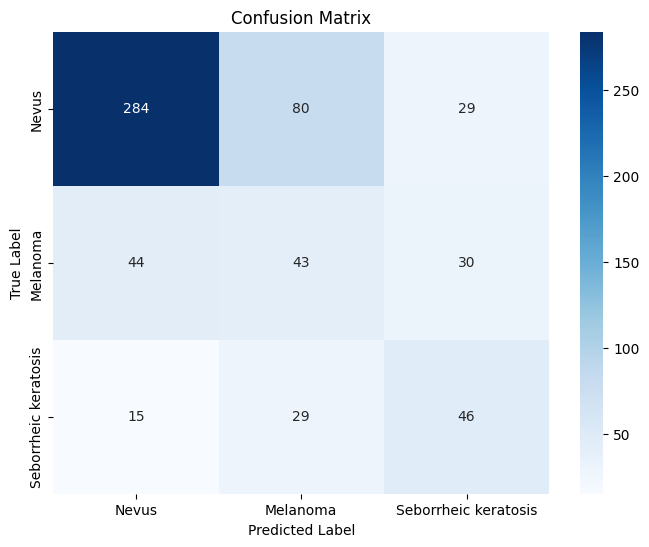

Classification Report:

                      precision    recall  f1-score   support

               Nevus       0.83      0.72      0.77       393
            Melanoma       0.28      0.37      0.32       117
Seborrheic keratosis       0.44      0.51      0.47        90

            accuracy                           0.62       600
           macro avg       0.52      0.53      0.52       600
        weighted avg       0.66      0.62      0.64       600



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Gather true labels and top-1 predictions
true_labels = []  # True labels for each query
top1_predictions = []  # Top-1 predicted labels for each query

for i in range(len(test_embeddings)):
    query_embedding = test_embeddings[i].unsqueeze(0)
    query_label = test_labels[i].item()  # Convert to scalar if tensor

    # Retrieve top-1 result
    top_indices = retrieve_images(query_embedding, train_embeddings, top_k=1)
    top_label = train_labels[top_indices[0][0]].item()  # Get the top-1 label

    true_labels.append(query_label)
    top1_predictions.append(top_label)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, top1_predictions)
class_names = ["Nevus", "Melanoma", "Seborrheic keratosis"]  

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label") 
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate Classification Report
report = classification_report(true_labels, top1_predictions, target_names=class_names)
print("Classification Report:\n")
print(report)

# Display Retrieved Images for query images

In [22]:
def display_retrieved_images(query_images, retrieved_images, query_labels, retrieved_labels, max_retrieved=10):
    # Label mapping dictionary
    label_mapping = {0: "Nevus", 1: "Melanoma", 2: "SK"}
    
    # Number of queries to process
    num_queries = len(query_images)
    
    # the plot with 1 row and (num_retrieved + 1) columns for each query
    fig, axes = plt.subplots(num_queries, max_retrieved + 1, figsize=(15, 5 * num_queries))
    
    if num_queries == 1:  # when we only have 1 query
        axes = [axes]
    
    for query_idx in range(num_queries):
        # the number of retrieved images does not exceed max_retrieved
        num_retrieved = min(len(retrieved_images[query_idx]), max_retrieved)
        
        # Display the query image with its label
        axes[query_idx][0].imshow(query_images[query_idx])
        axes[query_idx][0].set_title(f"Query Label: {label_mapping.get(query_labels[query_idx], 'Unknown')}")
        axes[query_idx][0].axis('off')
        
        # Display the retrieved images with their labels
        for i, (img, label) in enumerate(zip(retrieved_images[query_idx][:num_retrieved], retrieved_labels[query_idx][:num_retrieved])):
            axes[query_idx][i + 1].imshow(img)
            axes[query_idx][i + 1].set_title(f"Label: {label_mapping.get(label, 'Unknown')}")
            axes[query_idx][i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [23]:
# Select query indices from (0 to 299)
query_indices = [1, 5, 90, 150, 199, 240] 

query_images = [test_dataset[idx][0] for idx in query_indices] 
query_labels = [test_labels[idx].item() for idx in query_indices]  

# Retrieve top-10 most similar images 
top_k = 10
retrieved_images = []
retrieved_labels = []
for query_index in query_indices:
    query_embedding = test_embeddings[query_index].unsqueeze(0)
    top_indices = retrieve_images(query_embedding, train_embeddings, top_k=top_k)
    
    # Collect retrieved images and labels for the current query
    retrieved_images.append([combined_train_dataset[idx][0] for idx in top_indices[0]])
    retrieved_labels.append([train_labels[idx] for idx in top_indices[0]])

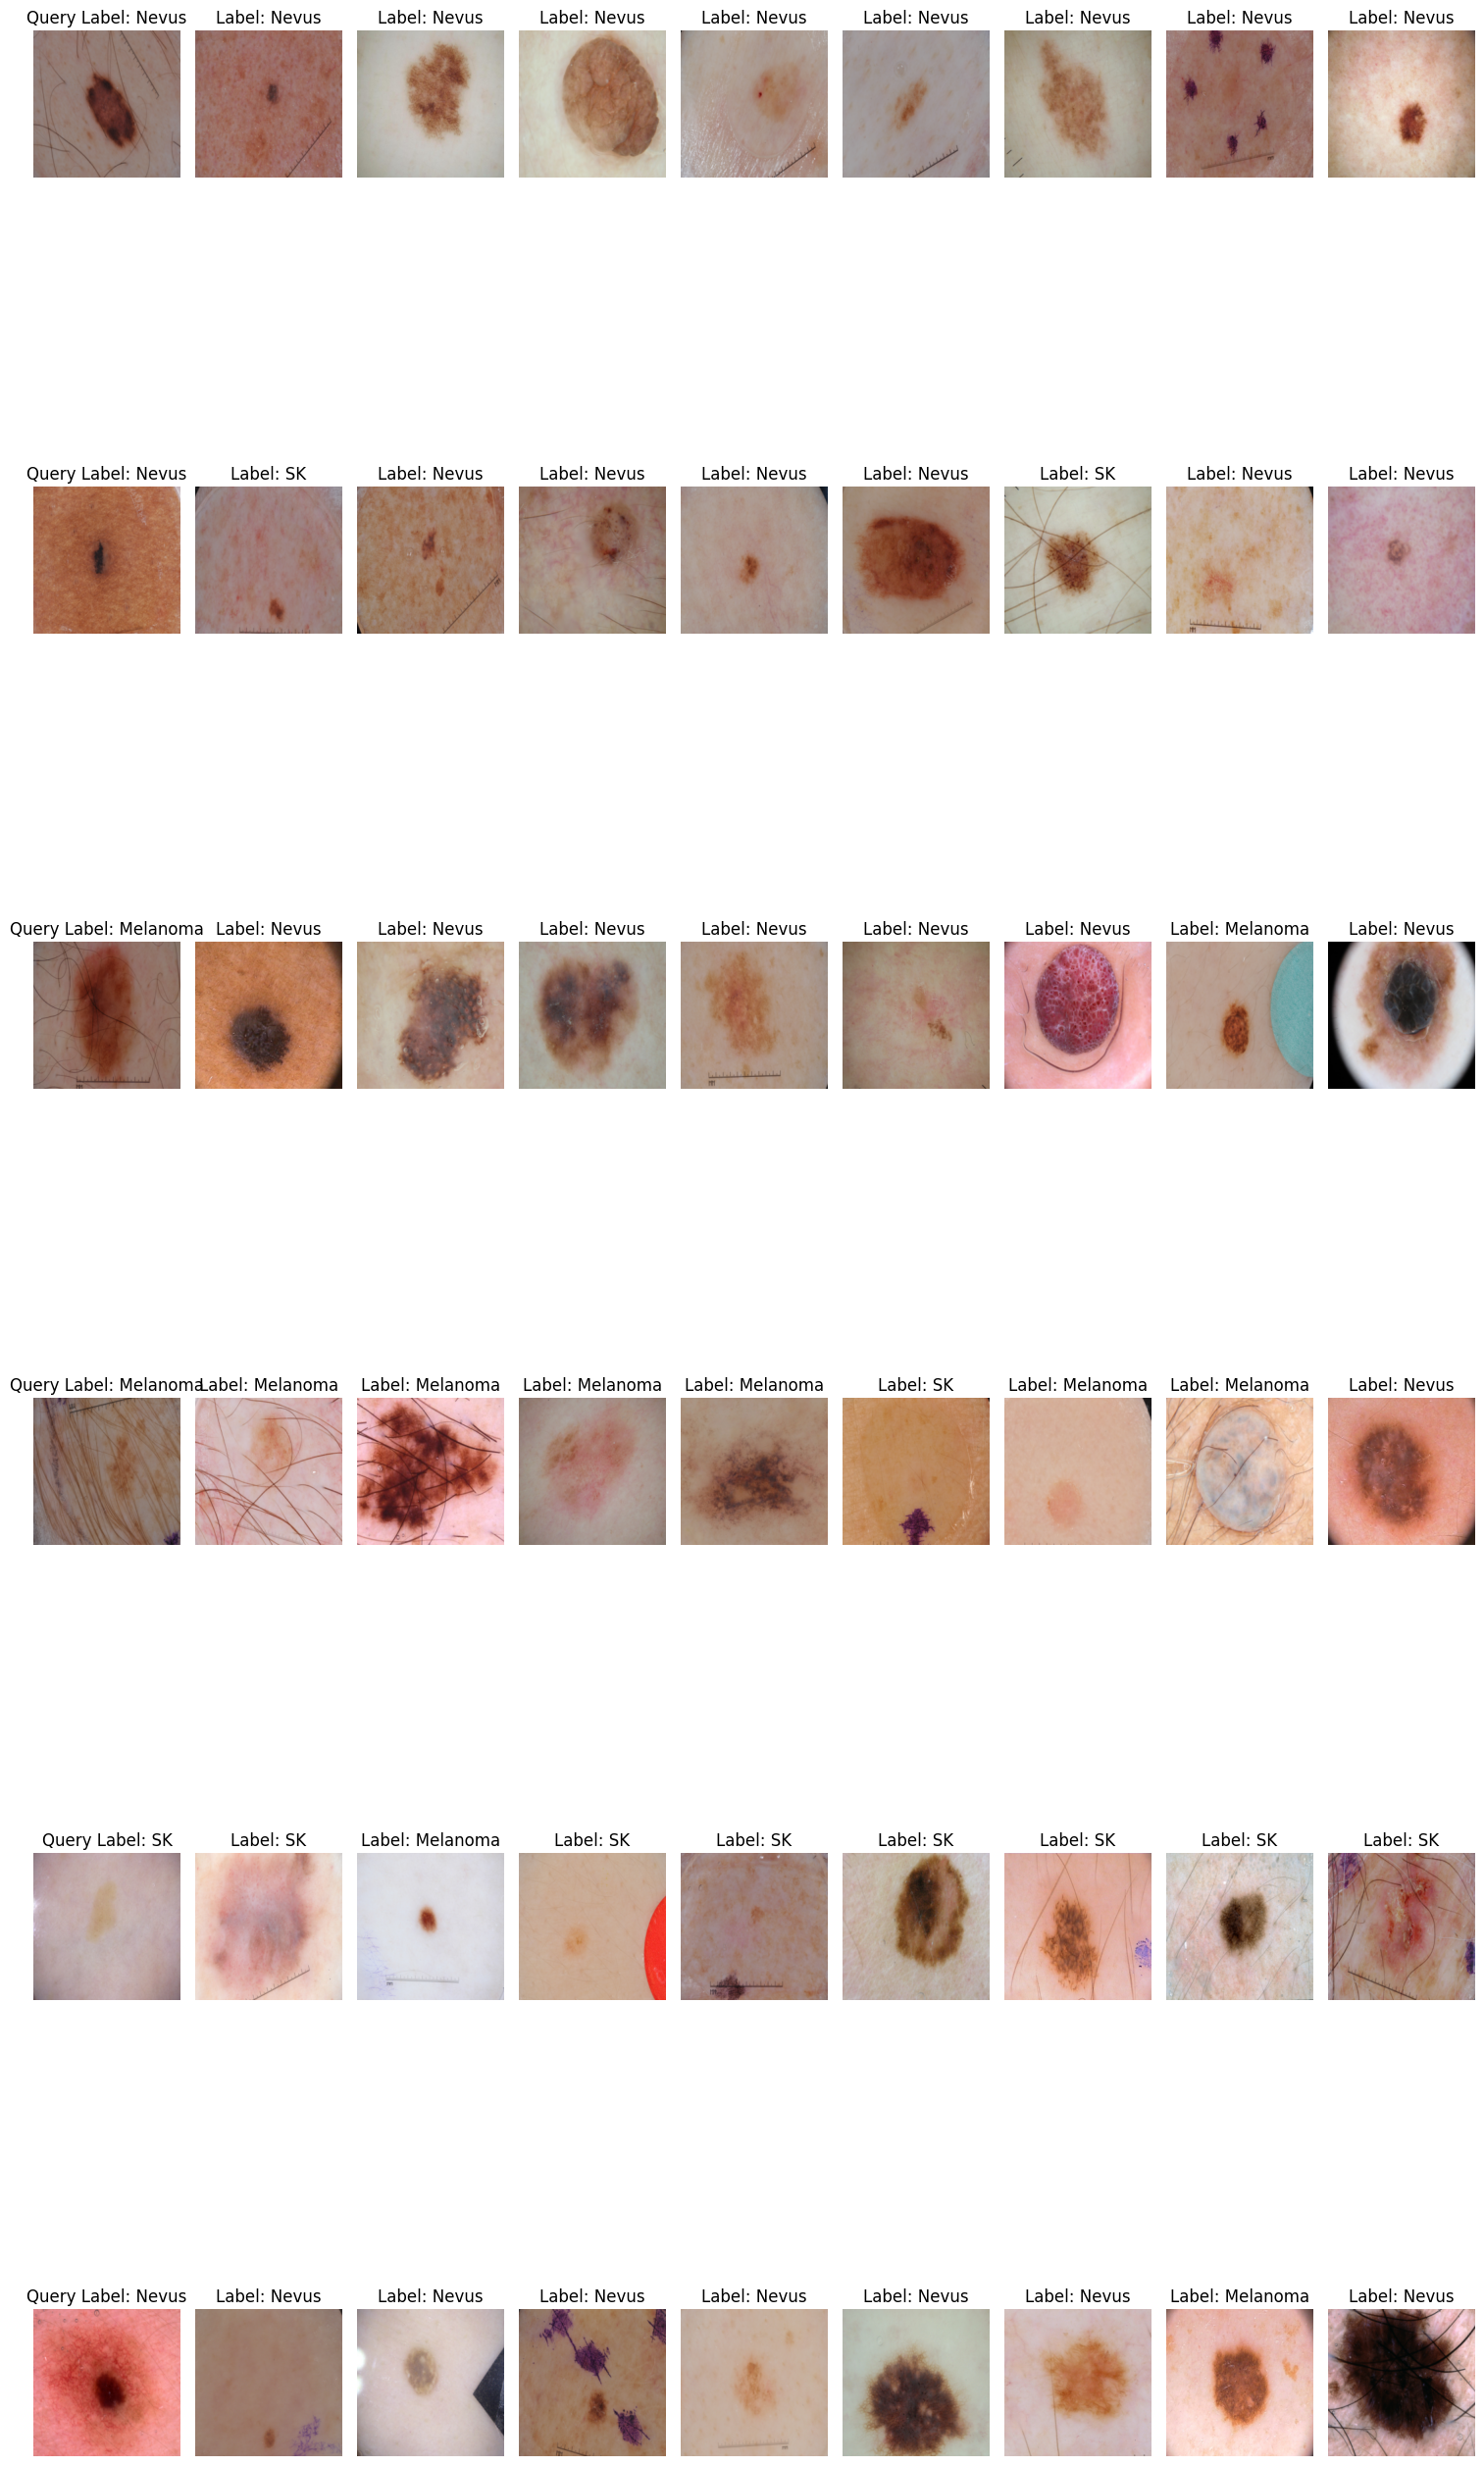

In [24]:
# Display the query images and retrieved images
display_retrieved_images(
    [img.permute(1, 2, 0).cpu().numpy() for img in query_images],  # Convert query images to HWC format
    [[img.permute(1, 2, 0).cpu().numpy() for img in imgs] for imgs in retrieved_images],
    query_labels,
    [[label.item() for label in labels] for labels in retrieved_labels],
    max_retrieved=8
)

# Clustering

In [16]:
!pip install scikit-learn-extra 
!pip install fuzzy-c-means 

In [17]:
from fcmeans import FCM
import warnings
from sklearn.metrics import silhouette_score

In [18]:
data = np.load("/kaggle/input/embeddings/embeddings_and_labels_(mAP_ 0.7457).npz")
# Extract the arrays
train_embeddings1 = data['train_embeddings']
train_labels1 = data['train_labels']
test_embeddings1 = data['test_embeddings']
test_labels1 = data['test_labels']

In [19]:
silhouette_score(train_embeddings1, train_labels1)

0.41000122

In [26]:
def retrieve_images_with_clusters(query_embedding, database_embeddings, database_labels, cluster_labels, query_cluster, top_k=10):
    # Filter database to only include embeddings in the same cluster as the query
    cluster_indices = np.where(cluster_labels == query_cluster)[0]
    cluster_embeddings = database_embeddings[cluster_indices]
    cluster_labels_filtered = database_labels[cluster_indices]

    # Calculate cosine similarity
    similarities = cosine_similarity(query_embedding, cluster_embeddings)
    indices = np.argsort(-similarities, axis=1)[:, :top_k]
    # Map indices back to original labels
    retrieved_labels = cluster_labels_filtered[indices].flatten().tolist()
    # print("retrieved_labels", retrieved_labels)
    return retrieved_labels

# Fuzzy c-means clustering

In [152]:
# Parameters for FCM clustering
n_clusters = 172
m = 1.5  
max_iter = 100  
error = 1e-7  
random_state = 42  
init = 'kmeans'
metric = 'cosine'

# Initialize and fit the FCM model
fcm_model = FCM(n_clusters=n_clusters, m=m, max_iter=max_iter, error=error, metric = metric,random_state=random_state)
fcm_model.fit(train_embeddings1) 

# Get the cluster labels for the training data
train_cluster_labels = fcm_model.u.argmax(axis=1) 

In [153]:
# Evaluate Retrieval Performance 
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  # True label of the query
    # print("query_label", query_label)
    # Get the cluster of the query
    query_cluster = fcm_model.predict(query_embedding.cpu().numpy())[0]
    # print("query_cluster", query_cluster) 

    # Retrieve top-K similar images within the same cluster
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels) 
    
# Calculate mAP, Precision@K, and Recall@K 
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")                                                       

for k in [1, 5, 10]: 
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k) 
    print(f"Precision@{k}: {precision_at_k:.4f}") 
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7584
Precision@1: 0.7033
Recall@1: 0.7033
Precision@5: 0.6630
Recall@5: 0.8983
Precision@10: 0.5705
Recall@10: 0.9100


# KMeans clustering

In [226]:
from sklearn.cluster import KMeans
# Define the number of clusters
n_clusters = 192
random_state = 100 
n_init = 40 
max_iter = 150 
tol = 1e-7

# Initialize and fit KMeans model
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=max_iter, tol=tol, n_init=n_init, random_state=100)
kmeans_model.fit(train_embeddings1)

# Get the cluster labels for the training data
train_cluster_labels = kmeans_model.labels_

In [227]:
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries 
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  # True label of the query
    
    # Get the cluster of the query
    query_cluster = kmeans_model.predict(query_embedding.cpu().numpy())[0]
    
    # Retrieve top-K similar images within the same cluster
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    ) 
    # Store the labels 
    query_labels.append(query_label) 
    retrieved_labels.append(top_labels) 
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}") 

for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k)
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k)
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7611
Precision@1: 0.6933
Recall@1: 0.6933
Precision@5: 0.6677
Recall@5: 0.9133
Precision@10: 0.5782
Recall@10: 0.9317


# K-Medoids clustering

In [78]:
from sklearn_extra.cluster import KMedoids
# Apply K-Medoids Clustering
n_clusters = 206    # Adjust this based on your dataset and requirements
init = 'k-medoids++'
max_iter = 200
tol = 1e-7
method = 'alternate'  

kmedoids_model = KMedoids(n_clusters=n_clusters, metric='euclidean', max_iter=max_iter, init = init, random_state=42)
kmedoids_model.fit(train_embeddings1)

# Assign cluster labels for train embeddings
train_cluster_labels = kmedoids_model.labels_

In [79]:
# Evaluate Retrieval Performance
query_labels = []  # True labels for queries
retrieved_labels = []  # Labels of retrieved items

for i in range(len(test_embeddings1)):
    query_embedding = torch.from_numpy(test_embeddings1[i]).unsqueeze(0)
    query_label = test_labels1[i]  # True label of the query

    # Get the cluster of the query
    query_cluster = kmedoids_model.predict(query_embedding.cpu().numpy())[0]

    # Retrieve top-K similar images within the same cluster
    top_labels = retrieve_images_with_clusters(
        query_embedding, train_embeddings1, train_labels1, train_cluster_labels, query_cluster, top_k=20
    )
    # Store the labels
    query_labels.append(query_label)
    retrieved_labels.append(top_labels)
    
# Calculate mAP, Precision@K, and Recall@K
map_score = calculate_map(query_labels, retrieved_labels) 
print(f"Mean Average Precision (mAP): {map_score:.4f}")

for k in [1, 5, 10]:
    precision_at_k = calculate_precision_at_k(query_labels, retrieved_labels, k=k) 
    recall_at_k = calculate_recall_at_k(query_labels, retrieved_labels, k=k) 
    print(f"Precision@{k}: {precision_at_k:.4f}")  
    print(f"Recall@{k}: {recall_at_k:.4f}") 

Mean Average Precision (mAP): 0.7615
Precision@1: 0.7067
Recall@1: 0.7067
Precision@5: 0.6667
Recall@5: 0.9050
Precision@10: 0.5750
Recall@10: 0.9267
